# Basic Data pre-processing and LSTM implementation into SHAP:
- This code contains most of the functionality in objects to try and seperate the large code blocks from model tuning and the integration into SHAP.
- The model has not been optimally tuned and almost all features are used.
- The dataset is downsampled because of the large time it takes for shapely value calculations.

Some things that could be added:
- General suggestions: Things to add or improve.
- Maybe extra layers (Conv, Relu, change LSTM layers, etc.)?
- Create a sequence from the data that is more elaborate than just each row.
- Find a efficient way to collect shapely values using batching (collect for each batch then combine) - would this be valid?
- Different types of datasets.
- General model tuning.
- SHAP visualisations.
- A dataset with labels and the shap values etc.
- Possibly using the dropped features? - sparse data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import time
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import random
import shap
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from captum.attr import IntegratedGradients


# Plot Metrics:
A basic function that plots the stored metrics in the LSTM model.

In [2]:
def plot_metrics(train, val, epochs, title):
    """
    Plot the training, validation, and test metrics.

    Parameters:
        - train_loss (list): Training metric
        - val_loss (list): Validation metric
        - test_loss (list): Test tmetric
        - epochs (int): The number of epochs.
    """
    sns.set_theme(style="whitegrid", palette="pastel")
    plt.figure(figsize=(8, 8))
    plt.plot(range(1, epochs + 1), train, label='Training', color=sns.color_palette("pastel")[0])
    plt.plot(range(1, epochs + 1), val, label='Validation', color=sns.color_palette("pastel")[1])
    #plt.plot(range(1, epochs + 1), test, label='Test', color=sns.color_palette("pastel")[2])
    plt.xlabel('Epochs')
    plt.ylabel(f"{title}")
    plt.title(f"{title}")
    plt.legend()
    plt.show()

# DataSampler:
This object does the loading and preprocessing of the data.
- Load the USNW-NB15 1, 2, 3, and 4 sets.
- Change all null labels to Normal **I am just assuming that the nulls are Normal here.
- Drop very sparse features: 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_ftp_login'.
- Drop values in 'dsport' that were loaded with errors (hexadecimal strings) - I think these were originally null.
- Change 'dsport' and 'sport' to numeric.
- For each dataset, downsample all 'Normal' labels to generic whilst using a mask to make sure no values directly before 'Normal' are sampled - the mask could be adapted.
- Combine the datasets by order 1, 2, 3, 4.
- Create a 70%, 15%, 15% split of the data by using a random starting point and slicing that many values towards the end for the validation and test data.
- Finally returns the training, validation, and test sets.

In [ ]:
class DataSampler:
    """
    DataSampler: Manages sampling and splitting of the USNW-NB15 dataset. Returns a training, validation, and test set.

    Initialisation:
        - train (None): The attributes that stores the train set.
        - val (None): The attributes that stores the validation set.
        - test (None): The attributes that stores the test set.
    """

    def __init__(self):
        self.train = None
        self.val = None
        self.test = None

    def sample_data(self, data, size, rs):
        """
        sample_data: Combines the USNW-NB15 1, 2, 3, 4 sets, does some basic cleaning, Use a random number generator to take slices for the validation
        and test set from the main data then splits into train, validation, and test set. Downsamples the data so that Normal labels match Generic in each set.
        Uses a mask to take only Normal values that do not precede a Non-Normal value.

        Parameters:
            - data (string): The dataset to use (currently only USNW-NB15 is supported).
            - type_of (string):  The type of sampling.
            - rs (int): The random seed for slicing operation.

        NOTE: Includes print outs to verify the process.
        """

        if data == 'full_data':
            feature_names = pd.read_csv('features2.csv' )

            #print('Set1')
            feature_names_list = feature_names['Name'].tolist()
            s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
            s1.columns = feature_names_list
            s1.loc[s1['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
            #print(s1['attack_cat'].value_counts())
            #print('Set2')
            feature_names_list = feature_names['Name'].tolist()
            s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)
            s2.columns = feature_names_list
            s2.loc[s2['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
            #print(s2['attack_cat'].value_counts())
            #print('Set3')
            feature_names_list = feature_names['Name'].tolist()
            s3 = pd.read_csv('UNSW-NB15_3.csv', header=None)
            s3.columns = feature_names_list
            s3.loc[s3['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
            #print(s3['attack_cat'].value_counts())
            #print('Set4')
            feature_names_list = feature_names['Name'].tolist()
            s4 = pd.read_csv('UNSW-NB15_4.csv', header=None)
            s4.columns = feature_names_list
            s4.loc[s4['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
            #print(s4['attack_cat'].value_counts())
            data = [s1, s2, s3, s4]
            i = 0

            while i < len(data):
                df = data[i]
                #print(f"Set{i + 1}")
                normal = df[df['attack_cat'] == 'Normal'].shape[0]
                generic = df[df['attack_cat'] == 'Generic'].shape[0]
                difference = normal - generic
                mask = df['Label'].shift(-1) != 1
                rows = df[(df['attack_cat'] == 'Normal') & mask]
                downsampled = rows.sample(n=difference, random_state=rs)
                df2 = df.drop(downsampled.index)
                #print(df2['attack_cat'].value_counts())
                data[i] = df2
                i += 1
            # Clean Labels.
            full_data = pd.concat([data[0], data[1], data[2], data[3]]).reset_index(drop=True)
            full_data['attack_cat'] = full_data['attack_cat'].str.replace(r'\s+', '', regex=True)
            full_data['attack_cat'] = full_data['attack_cat'].str.replace('Backdoors', 'Backdoor')
            # Drop Sparse Data.
            # NOTE: These values could also be transformed by adding 1 and setting nulls to 0.
            #full_data = full_data.drop(columns=['ct_ftp_cmd', 'ct_flw_http_mthd', 'is_ftp_login', 'srcip', 'dstip', 'dsport', 'sport'])
            full_data['proto'] = full_data['proto'].str.strip()
            full_data['state'] = full_data['state'].str.strip()
            full_data['service'] = full_data['service'].str.strip()
            print(len(full_data))
            dropped_rows = full_data[full_data['state'] == 'TXD']
            print('proto_TXD', dropped_rows['attack_cat'].value_counts())
            full_data = full_data[full_data['proto'] != 'TXD']
            #print('proto_urn', dropped_rows['attack_cat'].value_counts())
            #dropped_rows = full_data[full_data['proto'] == 'no']
            #print('proto_no', dropped_rows['attack_cat'].value_counts())
            #dropped_rows = full_data[full_data['proto'] == 'MAS']
            #print('proto_MAS', dropped_rows['attack_cat'].value_counts())
            #full_data = full_data[full_data['proto'] != 'rtp']
            #full_data = full_data[full_data['proto'] != 'urn']
            #full_data = full_data[full_data['proto'] != 'no']
            #full_data = full_data[full_data['proto'] != 'MAS']
            #print(len(full_data))
            # Remove error values created by nulls.
            #full_data['sport'] = full_data['sport'].apply(pd.to_numeric)
            #full_data = full_data[~full_data['dsport'].astype(str).str.startswith('0x')]
            #full_data['dsport'] = full_data['dsport'].apply(pd.to_numeric)
            slice_size = int(size * len(full_data))
            val_start = random.randrange(0, len(full_data) - 2 * slice_size)
            val_end = val_start + slice_size
            val_data = full_data.iloc[val_start:val_end]
            df = full_data.drop(val_data.index)
            test_start = random.randrange(0, len(df) - slice_size)
            test_end = test_start + slice_size
            test_data = df.iloc[test_start:test_end]
            train_data = df.drop(test_data.index)
                        
            return train_data, val_data, test_data

In [324]:
df = DataSampler()
# Type of data, proportion for slices, random seed.
train_data, val_data, test_data = df.sample_data('full_data', 0.2, 42)



C:\Users\adi_s\AppData\Local\Temp\ipykernel_31152\2703177020.py:35: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s1 = pd.read_csv('UNSW-NB15_1.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_31152\2703177020.py:41: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  s2 = pd.read_csv('UNSW-NB15_2.csv', header=None)


536764
proto_TXD attack_cat
Normal    2
Name: count, dtype: int64


In [323]:
class DataManager:
    """
    DataManager: Help manage the pre-processing of the USNW-NB15 dataset for an LSTM.

    Initialisation:
        - train (pd.Dataframe): The training data.
        - val (pd.Dataframe): The validation data.
        - test (pd.Dataframe): The teting data.
        - type_of (string): Specify if multiclass or other (currently only multi-class is supported).
    """
    def __init__(self, train, val, test, type_of):
        self.train = train
        self.val = val
        self.test = test
        if type_of == 'multi':
            for i in [self.train, self.val, self.test]:
                i.drop(columns=['Label'], inplace=True)    
            self.label = 'attack_cat'
        

    def encode(self, encoder_type, columns):    
        # Initialize the encoder based on the input type
        if encoder_type == 'onehot':
            encoder = OneHotEncoder(sparse_output=False)
        elif encoder_type == 'label':
            encoder = LabelEncoder()
        for column_name in columns:
            if encoder_type == 'onehot':
            # OneHotEncode the column
                encoded_train = encoder.fit_transform(self.train[[column_name]])
                encoded_val = encoder.transform(self.val[[column_name]])
                encoded_test = encoder.transform(self.test[[column_name]])

                encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([column_name]))
                encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out([column_name]))
                encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([column_name]))

            # Drop the original column and append the scaled, encoded columns
                data_train = pd.concat([data_train.drop(columns=[column_name]), encoded_train_df], axis=1)
                data_val = pd.concat([data_val.drop(columns=[column_name]), encoded_val_df], axis=1)
                data_test = pd.concat([data_test.drop(columns=[column_name]), encoded_test_df], axis=1)


            return data_train, data_val, data_test

    def standardise(self, type_of):
        """
        standardise: Standardises the features of the train and test datasets.

        Parameters:
            - type_of (string): Choose the standardisation ('standard' or 'minmax').
        """
        train_features = self.train.drop(columns=[self.label])
        val_features = self.val.drop(columns=[self.label])
        test_features = self.test.drop(columns=[self.label])
        train_label = self.train[self.label]
        val_label = self.val[self.label]
        test_label = self.test[self.label]
        if type_of == 'minmax':
            scaler = MinMaxScaler()
        elif type_of == 'standard':
            scaler = StandardScaler()
        scaled_train = scaler.fit_transform(train_features)
        scaled_val = scaler.transform(val_features)
        scaled_test = scaler.transform(test_features)
        self.train = pd.DataFrame(scaled_train, columns=train_features.columns, index=self.train.index)
        self.train[self.label] = train_label
        self.val = pd.DataFrame(scaled_val, columns=val_features.columns, index=self.val.index)
        self.val[self.label] = val_label
        self.test = pd.DataFrame(scaled_test, columns=test_features.columns, index=self.test.index)
        self.test[self.label] = test_label

    def get_sequence(self):
        """
        get_sequence: Converts the Dtaframe to a sequence for each row and the corresponding label.
        
        Parameters:
            - batch_size (int): The batch size to use in DataLoader.

        Returns:
            - train_loader (DataLoader): Dataloader for the training data.
            - val_loader (DataLoader): Dataloader for the validation data.
            - test_loader (DataLoader): Dataloader for the test data.
        """
        
        train_seq = torch.tensor(self.train.drop(columns=[self.label]).values, dtype=torch.float32)
        val_seq = torch.tensor(self.val.drop(columns=[self.label]).values, dtype=torch.float32)
        test_seq = torch.tensor(self.test.drop(columns=[self.label]).values, dtype=torch.float32)
        train_label = torch.tensor(self.train[self.label].values, dtype=torch.long)
        val_label = torch.tensor(self.val[self.label].values, dtype=torch.long)
        test_label = torch.tensor(self.test[self.label].values, dtype=torch.long)

        # Add dimension for LSTM.
        train_seq = train_seq.unsqueeze(1)
        val_seq = val_seq.unsqueeze(1)
        test_seq = test_seq.unsqueeze(1)

        train_dataset = TensorDataset(train_seq, train_label)
        val_dataset = TensorDataset(val_seq, val_label)
        test_dataset = TensorDataset(test_seq, test_label)
        
        return train_dataset, val_dataset, test_dataset
    
    def get_weights(self, type_of):
        """
        get_weights: Calculate the weights of the labels for the given dataset. Used in Cross Entropy Loss criterion.
        
        Parameters:
            - type_of (string): The dataset to use (train, val, test).

        Returns:
            - class_weights (tensor): The class weights for the label.
        """
        if type_of == 'train':
            data = self.train
        elif type_of == 'val':
            data = self.val
        elif type_of == 'test':
            data = self.test
        labels = data[self.label].values
        class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
        return torch.tensor(class_weights, dtype=torch.float)
#dm.label_encode()
dm = DataManager(train_data, val_data, test_data, 'multi')
train, test, val = dm.encode('onehot', ['proto'])

ValueError: Found unknown categories ['udt'] in column 0 during transform

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
import pandas as pd

def encode_and_scale(data_train, data_val, data_test, encoder_type='onehot', scaler_type='minmax', columns=None):
    """
    This function applies the encoder and scaler to the specified columns of the data.

    Parameters:
        - data_train: The training DataFrame containing the data
        - data_val: The validation DataFrame containing the data
        - data_test: The test DataFrame containing the data
        - encoder_type: The type of encoder ('onehot' or 'label')
        - scaler_type: The type of scaler ('minmax' or 'standard')
        - columns: List of columns to encode and scale (default is None, applies to all columns)

    Returns:
        - The modified DataFrames with the encoded and scaled columns
    """
    if columns is None:
        columns = data_train.columns  # If no columns specified, apply to all columns
    
    # Initialize the encoder based on the input type
    if encoder_type == 'onehot':
        encoder = OneHotEncoder(sparse_output=False)
    elif encoder_type == 'label':
        encoder = LabelEncoder()

    # Initialize the scaler based on the input type
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()

    for column_name in columns:
        if encoder_type == 'onehot':
            # OneHotEncode the columnt':
            encoded_train = encoder.fit_transform(data_train[[column_name]])
            encoded_val = encoder.transform(data_val[[column_name]])
            encoded_test = encoder.transform(data_test[[column_name]])

            encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out([column_name]))
            encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out([column_name]))
            encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out([column_name]))

            # Apply scaling to the one-hot encoded columns
            scaled_train = scaler.fit_transform(encoded_train_df)
            scaled_val = scaler.transform(encoded_val_df)
            scaled_test = scaler.transform(encoded_test_df)

            scaled_train_df = pd.DataFrame(scaled_train, columns=encoder.get_feature_names_out([column_name]))
            scaled_val_df = pd.DataFrame(scaled_val, columns=encoder.get_feature_names_out([column_name]))
            scaled_test_df = pd.DataFrame(scaled_test, columns=encoder.get_feature_names_out([column_name]))

            # Drop the original column and append the scaled, encoded columns
            data_train = pd.concat([data_train.drop(columns=[column_name]), scaled_train_df], axis=1)
            data_val = pd.concat([data_val.drop(columns=[column_name]), scaled_val_df], axis=1)
            data_test = pd.concat([data_test.drop(columns=[column_name]), scaled_test_df], axis=1)

        elif encoder_type == 'label':
            # LabelEncode the column
            data_train[column_name] = encoder.fit_transform(data_train[column_name])
            data_val[column_name] = encoder.transform(data_val[column_name])
            data_test[column_name] = encoder.transform(data_test[column_name])

            # Apply scaling to the encoded column (now numeric)
            data_train[column_name] = scaler.fit_transform(data_train[column_name])
            data_val[column_name] = scaler.transform(data_val[column_name])
            data_test[column_name] = scaler.transform(data_test[column_name])

    return data_train, data_val, data_test

# Example usage:

# Columns to encode and scale
columns_to_process = ['proto']  # Add any other columns you want to process

# Apply one-hot encoding and MinMax scaling to specific columns
train_data, val_data, test_data = encode_and_scale(train_data, val_data, test_data, encoder_type='onehot', scaler_type='minmax', columns=columns_to_process)

In [299]:
print(train_data.columns)

Index(['state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss',
       'service', 'Sload',
       ...
       'proto_visa', 'proto_vmtp', 'proto_vrrp', 'proto_wb-expak',
       'proto_wb-mon', 'proto_wsn', 'proto_xnet', 'proto_xns-idp', 'proto_xtp',
       'proto_zero'],
      dtype='object', length=175)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Initialize the OneHotEncoder and MinMaxScaler
encoder = OneHotEncoder(sparse_output=False)
scaler = MinMaxScaler()
train_encoded = encoder.fit_transform(train_data[['proto']])
val_encoded = encoder.transform(val_data[['proto']])
test_encoded = encoder.transform(test_data[['proto']])

# Convert the encoded values back to DataFrames with column names
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['proto']))
val_encoded_df = pd.DataFrame(val_encoded, columns=encoder.get_feature_names_out(['proto']))
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['proto']))

# Apply scaling to the encoded 'proto' columns
train_encoded_scaled = scaler.fit_transform(train_encoded_df)
val_encoded_scaled = scaler.transform(val_encoded_df)
test_encoded_scaled = scaler.transform(test_encoded_df)

# Convert the scaled data back to DataFrames
train_encoded_scaled_df = pd.DataFrame(train_encoded_scaled, columns=encoder.get_feature_names_out(['proto']))
val_encoded_scaled_df = pd.DataFrame(val_encoded_scaled, columns=encoder.get_feature_names_out(['proto']))
test_encoded_scaled_df = pd.DataFrame(test_encoded_scaled, columns=encoder.get_feature_names_out(['proto']))

# Drop the original 'proto' column and add the scaled one-hot encoded columns
train_data = pd.concat([train_data.drop(columns=['proto']), train_encoded_scaled_df], axis=1)
val_data = pd.concat([val_data.drop(columns=['proto']), val_encoded_scaled_df], axis=1)
test_data = pd.concat([test_data.drop(columns=['proto']), test_encoded_scaled_df], axis=1)

In [212]:
print(train_data.columns)

Index(['proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
       'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin',
       'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
       'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt',
       'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat'],
      dtype='object')


# DataManager:
This object contains some base pre-processing functions that transform and prepare the data for LSTM.
- Add the datasets to the object (train, validation, test).
- Remove binary labels.
- Choose to either LabelEncode or OneHotEncode 'srcip', 'dstip', 'proto', 'state', 'service' features (automatically takes care of the label) - might have some conflicts       depending on the sampler.
- Standardise the data using StandardScaler or MinMaxScaler.
- Get the weights for CrossEntropyLoss (I have not updated this since the last LSTM).
- Prepare a sequence for the LSTM. Creates torch tensors of the train, validation, and test set. Adds an extra dimension (1) to the features and combines the labels and features into a tensor then returns it.

# Run Preprocessing steps:
Run all the preprocessing through the objects (sport and dport have been dropped).
- Try different split percentages and seeds for the sample_data.
- DataManager loading is only for multi-class currently.
- Label encode is called with no parameters on categorical columns including the labels.
- Standardise the data using minmax or standard.
- Sequence is automatically called at the moment with no parameters.

In [ ]:

#
#
#

#
# Create a basic sequence for each row (basically a numpy.array() conversion of a DataFrame).
#train_data, val_data, test_data = dm.get_sequence()

KeyError: "['Label'] not found in axis"

In [277]:
dm.encode('onehot', 'service')

In [278]:
dm.encode('onehot', 'proto')

In [281]:
dm.encode('label', 'attack_cat')

In [283]:
dm.train.columns

Index(['proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
       'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin',
       'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
       'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt',
       'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat'],
      dtype='object')

In [282]:
dm.standardise('minmax') 

ValueError: could not convert string to float: 'udp'

# LSTM Model:
The LSTM model calculates an output for each sequence (row) to the given label internally then it is combined for the CrossEntropyLoss prediction.
- Try different number of layers or change the hidden size.
- Tune the model using the optimizer.
- Add weights to CrossEntropyLoss.
- Save and load models.
- Get the GradientExplainer after each run on the test set (this is calculated quickly). - The testing function could be adjusted so it is called outside the run function that way we can rerun the model for shap if needed.
- Get the different metrics stored in the model as attributes and put them into visualisations.
- Get the actual and predicted labels to filter out the test set.

In [269]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers, device, save_dir):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.device = device
        self.save_dir = save_dir
        self.to(self.device)
        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.epoch_time = []
        self.test_accuracy = None
        self.test_loss = None
        self.test_f1 = None
        self.test_predicted = []
        self.test_actual = []

    def forward(self, x):
        """
        forward: The forward pass for the LSTM. Calculates the label for the same row.
        This is a magic method called when the model is called (model(input)).

        Parameters:
            - x (tensor): The input sequence for the LSTM.

        Returns:
            - output (tensor): Returns the output after the LSTM layer.

        """
        lstm_out, _ = self.lstm(x)
        final_hidden_state = lstm_out[:, -1, :]
        output = self.fc(final_hidden_state)
        return output

    def calculate_accuracy_f1(self, predictions, labels):
        """
        calculate_accuracy_f1: A helper function to help modularise the code. Calculates accuracy and
        f1 macro (average)

        Parameters:
            - predictions (tensor): The predictions given by CrossEntropyLoss()
            - labels (tensor): The actual labels of the test data.
        
        Returns:
            - accuracy (float): The accuracy score.
            - f1 (float): The macro f1 score.
        
        """
        preds = torch.argmax(predictions, dim=1)
        accuracy = accuracy_score(labels.cpu(), preds.cpu())
        f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        return accuracy, f1

    def run(self, train_data, val_data, test_data, criterion, optimizer, epochs, save_factor):
        """
        run: Run the model on the train, val data for each epoch. Evaluate on the test data at the end
        of all epochs. Returns an explainer object based on the gradient of all datapoints in the test set and model.

        Parameters:
            - train_data (TensorDataset): The tensor holding the train features and labels.
            - val_data (TensorDataset): The tensor holding the validation features and labels.
            - test_data (TensorDataset): The tensor holding the test features and labels.
            - criterion (nn.CrossEntropyLoss): The probability calculation for logits.
            - optimizer (optim.Adam): The automatic regularisation optimizer.
            - epochs (int): The number of epochs to train.
            - save_factor (int): The factor at which to save the model during training.

        Returns:
            - explainer (shap.GradientExplainer): The calculated explainer for all data on the
            test set.

        """
        # Split the tensors.
        train_seq, train_label = train_data.tensors
        val_seq, val_label = val_data.tensors
        test_seq, test_label = test_data.tensors
        train_seq, train_label = train_seq.to(self.device), train_label.to(self.device)
        val_seq, val_label = val_seq.to(self.device), val_label.to(self.device)
        test_seq, test_label = test_seq.to(self.device), test_label.to(self.device)

        for epoch in range(epochs):
            start_time = time.time()
            self.train()
            optimizer.zero_grad()
            # Forward pass.
            outputs = self(train_seq)
            loss = criterion(outputs, train_label)
            loss.backward()
            optimizer.step()
            train_accuracy, train_f1 = self.calculate_accuracy_f1(outputs, train_label)

            self.eval()
            with torch.no_grad():
                val_outputs = self(val_seq)
                val_loss = criterion(val_outputs, val_label)
                val_accuracy, val_f1 = self.calculate_accuracy_f1(val_outputs, val_label)
            self.train_loss.append(loss.item())
            self.val_loss.append(val_loss.item())
            self.train_accuracy.append(train_accuracy)
            self.val_accuracy.append(val_accuracy)
            self.train_f1.append(train_f1)
            self.val_f1.append(val_f1)
            epoch_time = time.time() - start_time
            self.epoch_time.append(epoch_time)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
            print(f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")
            if (epoch + 1) % save_factor == 0:
                self.save_model(epoch + 1)
        self.eval()
        with torch.no_grad():
            test_outputs = self(test_seq)
            test_loss = criterion(test_outputs, test_label)
            test_accuracy, test_f1 = self.calculate_accuracy_f1(test_outputs, test_label)
            self.test_accuracy = test_accuracy
            self.test_loss = test_loss.item()
            self.test_f1 = test_f1
            self.test_pred = torch.argmax(test_outputs, dim=1).cpu().numpy()
            self.test_actual = test_label.cpu().numpy()
            print(f"Test Loss: {self.test_loss:.4f}, Test Accuracy: {self.test_accuracy:.4f}, Test F1: {self.test_f1:.4f}")

        # NOTE: We cannot use no grad with SHAP explainers due to conflicts.
        explainer = shap.GradientExplainer(self, test_seq)
        return explainer

    def save_model(self, epoch):
        """
        save_model: Save the model state_dict for the given factor. Approx 1 megabyte each.

        Parameters:
            - The current epoch that is being saved.

        """
        
        checkpoint_path = os.path.join(self.save_dir, f"lstm_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
        }, checkpoint_path)

    def load_model(self, epoch):
        """
        load_model: Load a state_dict of a model.

        Parameters:
            - epoch (int): The epoch to load.

        """
        checkpoint_path = os.path.join(self.save_dir, f"lstm_epoch_{epoch}.pt")
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint['model_state_dict'])

# Run the LSTM model:
This section runs the LSTM model and creates an GradientExplainer object on the input of the model.
- Change the hidden size or number of layers.
- Add weights and test.
- Change the optimizer settings.
- Run the model for a given number of epochs and specify the save intervals.

In [270]:
input_size = 40
# Change hidden size for complexity.
hidden_size = 128
num_labels = len(np.unique(train_data.tensors[1]))
# Maybe try an additional layer?
num_layers = 1
# NOTE: Currently stuck with cpu as the shap_values calculation fails when mounted on GPU.
device = torch.device("cpu")
model = LSTM_Model(input_size, hidden_size, num_labels, num_layers, device, 'model')
criterion = nn.CrossEntropyLoss()
# Lower LR and increase epochs so we make sure not to miss the minimum.
# NOTE: The model continues to converge and could be optimised for more epochs to find the minimum
# then tuned with lr for time.
optimizer = optim.Adam(model.parameters(), lr=0.04)
explainer = model.run(train_data, val_data, test_data, criterion, optimizer, 200, 50)

AttributeError: 'DataFrame' object has no attribute 'tensors'

# Random Forest Implementation:
The Random forest seems to consistently achieve a higher accuracy than the lstm.
- RF 95.09 %
- LSTM 92.0 %

The LSTM Model also takes much longer.
- RF 33.2 seconds - 100 estimators.
- LSTM 5 min 45 seconds - 200 epochs

In [53]:
# Seperate the data from the tensors and use the same train and test set for Random Forest.
tr_data, labels = train_data.tensors
tr_data = tr_data.squeeze()
tr_data = pd.DataFrame(tr_data)
tr_data['labels'] = pd.DataFrame(labels)
te_data, labels = train_data.tensors
te_data = te_data.squeeze()
te_data = pd.DataFrame(te_data)
te_data['labels'] = pd.DataFrame(labels)
X_train = tr_data.drop(columns='labels')
y_train = tr_data['labels']
X_test = te_data.drop(columns='labels')
y_test = te_data['labels']
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9509

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.19      0.31      1890
           1       0.95      0.15      0.26      1640
           2       0.52      0.59      0.55     11232
           3       0.76      0.87      0.81     30772
           4       0.92      0.91      0.91     17412
           5       1.00      0.99      0.99    122848
           6       1.00      1.00      1.00    125515
           7       1.00      0.86      0.93      9528
           8       1.00      1.00      1.00      1058
           9       0.97      0.93      0.95       123

    accuracy                           0.95    322018
   macro avg       0.91      0.75      0.77    322018
weighted avg       0.96      0.95      0.95    322018



# SHAP Integration:
This section contains a basic implementation of calculating shapely values, transforming the results, then plotting.
- Seperate labels from shapely data (not sure why it was in there?).
- Calculate SHAP values, this takes a long time sometimes. 1000 rows is around 3 minutes and 100, 000 takes 7.5 hours.
- Remove the extra dimension generated by the LSTM and shap value calculations (this is valid as sequence is 1 but am not sure how it will be if we use a more complex sequence).
- Remove extra dimension set into the preprocessed data.
- Create Dataframes and add feature names.
- Create basic summary_plot.

In [56]:
# Use .tensors to individually access the feature columns.
shap_data = test_data.tensors[0]
shap_data = shap_data[:10000]

# Compare SHAP Calculations for Random Forest and LSTM:
- Random Forest seems to take a bit longer because number of estimators. However, even when the estimators is reduced to 10 Random Forest has 94.5% accuracy.

In [57]:
# We have the gradient which is calculated quickly now we can calculate
# the shap values for any slice in the data without having to worry about batches.
# We can select certain labels by doing a conversion to a dataframe adding labels and 
# indexing it in test_seq.
# Takes a long time for 1000 (Maybe can use cuda?). - 3:17. (Full data - 7.5 hrs approx)
shap_values = explainer.shap_values(shap_data)

KeyboardInterrupt: 

In [57]:

explainer = shap.TreeExplainer(rf_classifier)

In [ ]:
print(shap_values.shape)

In [ ]:
# Use X_test cos the extra dimension.
shap_values_tree = explainer.shap_values(shap_data.squeeze())

In [59]:
print(shap_values.shape)
shap_values2 = shap_values.squeeze()

(1000, 1, 44, 10)


In [60]:
# Remove sequence dimension.
# NOTE: When using sequences of more than 1, the shapely values need to be calculated
# collectively for the label (average etc.).
data = shap_data.squeeze().numpy()
data.shape

(1000, 44)

# SHAP values DataFrame:
This section creates two DataFrames that match in index (I assume).
- Use feature names of the original dataset to select specific features.
- Add the predicted or actual labels of the original dataset and filter.
- Use the original Dataset as an index to the SHAP values dataset and create two matching DataFrames.
- Pass the DataFrames into SHAP visualisations.

In [61]:
# NOTE: This section is ommited for now.
# Get original feature columns and add to the corresponding shap data.
#col_data = dm.test.drop(columns=['attack_cat'])
#columns = col_data.columns
# Convert to DataFrame for easy filtering.
#shap_data = pd.DataFrame(data, columns=columns)
#shap_values2 = pd.DataFrame(shap_values2)

#shap_data.to_csv('shap_data.csv')
#shap_values2.to_csv('shap_values.csv')

In [62]:
print('LSTM Model')
shap.summary_plot(shap_values2, shap_data)
print('Random Forest')
shap.summary_plot(shap_values_tree, shap_data)

LSTM Model


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [ ]:
# Selecting label 0 - Normal.
shap_values2 = shap_values2[:, :, 6]
print(shap_values2.shape)
shap_values_tree = shap_values_tree[:, :, 6]
print(shap_values_tree.shape)

(1000, 44)
(1000, 44)


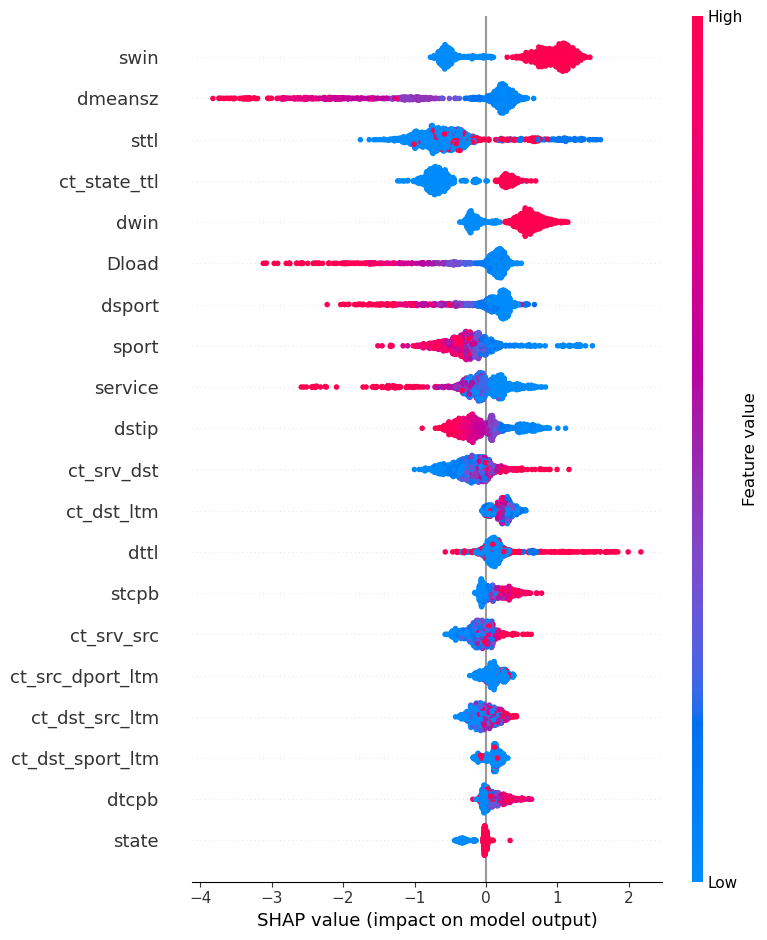

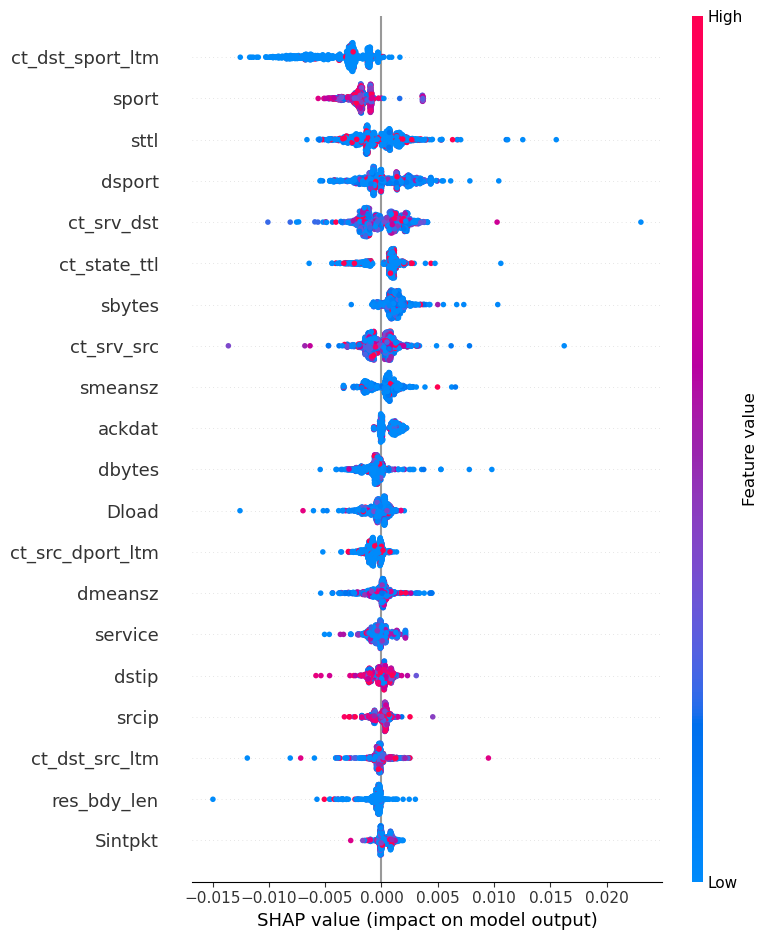

In [ ]:
print('LSTM Model')
shap.summary_plot(shap_values2, shap_data)
print('Random Forest')
shap.summary_plot(shap_values_tree, shap_data)

# Try again with 1 Estimator:

In [ ]:
# Seperate the data from the tensors and use the same train and test set for Random Forest.
tr_data, labels = train_data.tensors
tr_data = tr_data.squeeze()
tr_data = pd.DataFrame(tr_data)
tr_data['labels'] = pd.DataFrame(labels)
te_data, labels = train_data.tensors
te_data = te_data.squeeze()
te_data = pd.DataFrame(te_data)
te_data['labels'] = pd.DataFrame(labels)
X_train = tr_data.drop(columns='labels')
y_train = tr_data['labels']
X_test = te_data.drop(columns='labels')
y_test = te_data['labels']
rf_classifier = RandomForestClassifier(n_estimators=1, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9450

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.25      0.36      1766
           1       0.45      0.16      0.24      1381
           2       0.46      0.52      0.49      9644
           3       0.74      0.82      0.78     27714
           4       0.90      0.87      0.89     16438
           5       1.00      0.99      0.99    131676
           6       1.00      1.00      1.00    123321
           7       0.95      0.82      0.88      8991
           8       0.92      0.89      0.90       979
           9       0.66      0.77      0.71       108

    accuracy                           0.95    322018
   macro avg       0.77      0.71      0.72    322018
weighted avg       0.95      0.95      0.94    322018



In [ ]:
explainer = shap.TreeExplainer(rf_classifier)
shap_values_tree = explainer.shap_values(X_test[:100])

(100, 44)


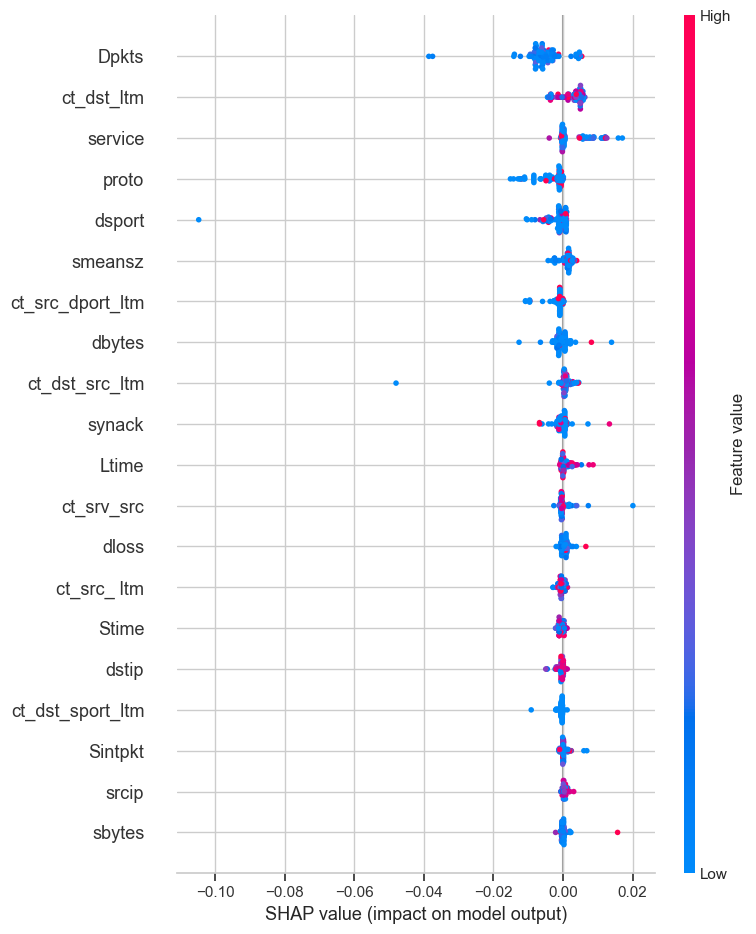

In [ ]:
# Select label 0 - Normal.
shap_values_tree = shap_values_tree[:, :, 6]
print(shap_values_tree.shape)
print('Random Forest 1 Estimator (Decision Tree)')
shap.summary_plot(shap_values_tree, shap_data[:100])

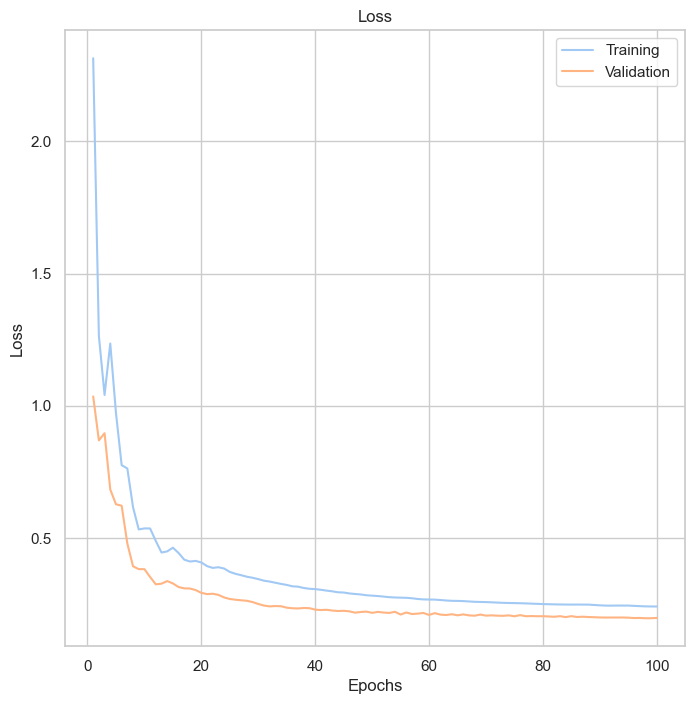

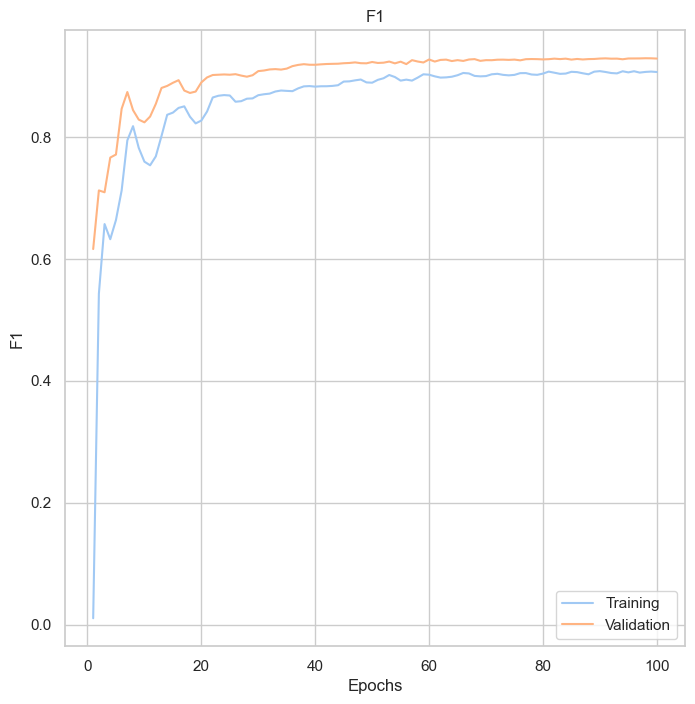

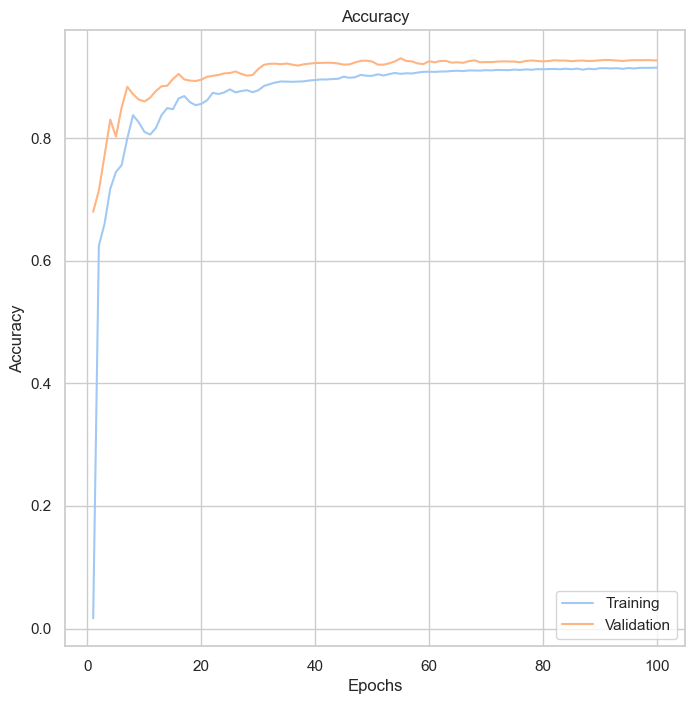

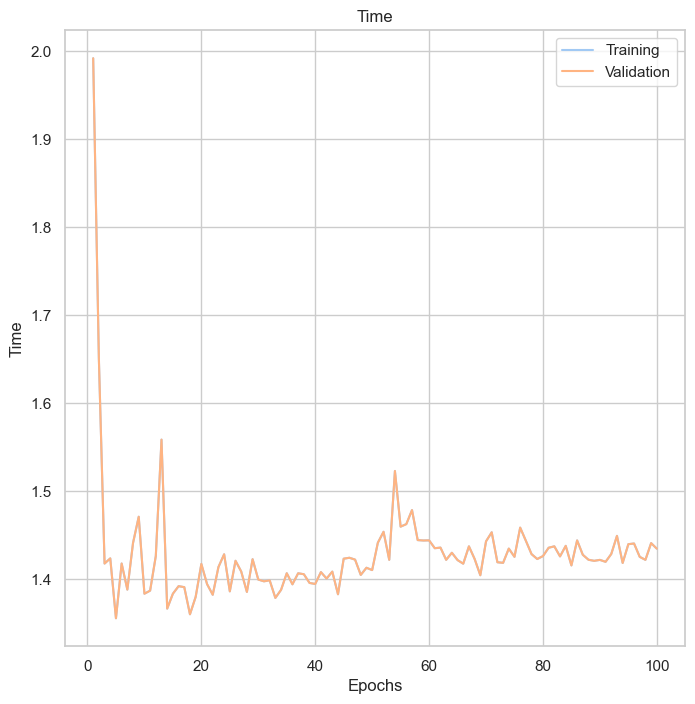

In [ ]:
# All metrics are held within the model and can be called.
plot_metrics(model.train_loss, model.val_loss, 100, 'Loss')
plot_metrics(model.train_f1, model.val_f1, 100, 'F1')
plot_metrics(model.train_accuracy, model.val_accuracy, 100, 'Accuracy')
# There is only 1 time but omits errors if wanting to just plot 1.
plot_metrics(model.epoch_time, model.epoch_time, 100, 'Time')

# Predicted and actual labels. Add the labels to the original data and use it
# to filter certain rows. For example false positives.
y_pred = model.test_pred
actual = model.test_actual